## Filtrado de EMG

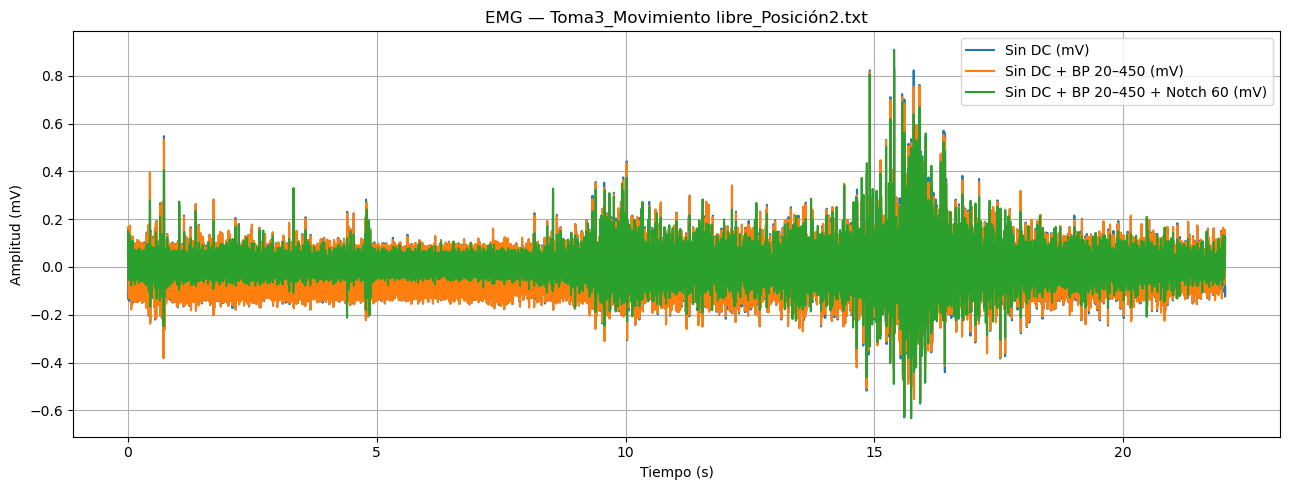

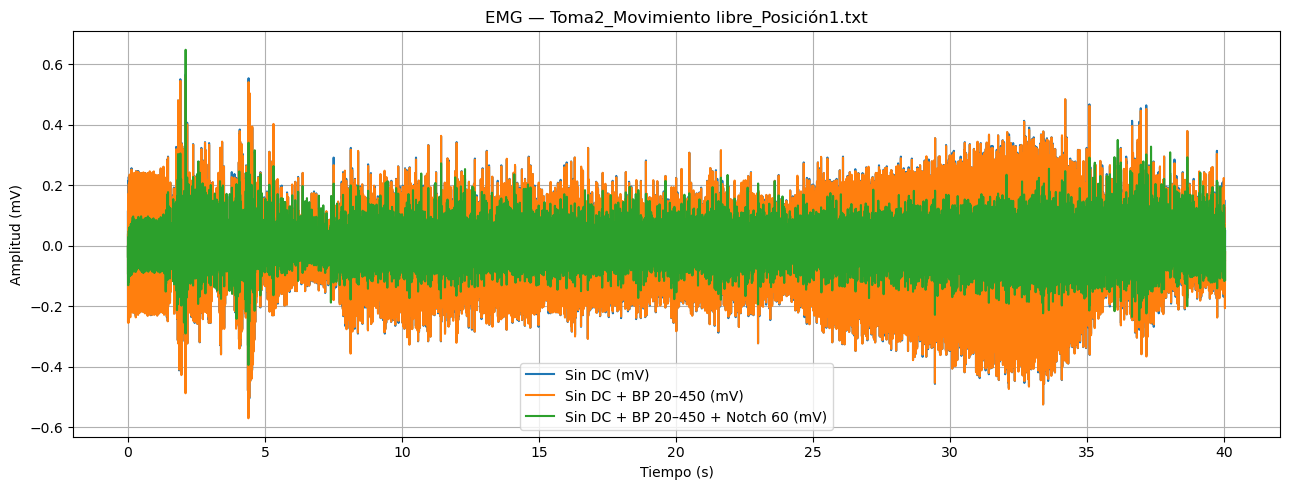

In [35]:
##FILTRO  BUTERWORDTH PASABANDA 20-450 + NOTCH 60Hz
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import filtfilt

# ==============================
# Parámetros del sistema (BITalino)
# ==============================
fs       = 1000
canal    = 5
Vcc      = 3.3
GAIN_EMG = 1009
ADC_BITS = 10
ADC_MAX  = (2**ADC_BITS) - 1

# ==============================
# Archivos de filtros (pyFDA: 2 columnas -> b, a)
# ==============================
archivo_bp    = r"C:\Users\RODRIGO\Desktop\GRUPO-04-ISB-2025-II\Laboratorios\Laboratorio 6 - Filtros\Extras\F20_EMG\Butterworth.csv"
archivo_notch = r"C:\Users\RODRIGO\Desktop\GRUPO-04-ISB-2025-II\Laboratorios\Laboratorio 6 - Filtros\Extras\F60_EMG\Butterworth.csv"

# Cargar coeficientes una sola vez
arr_bp    = np.loadtxt(archivo_bp, delimiter=',')
arr_notch = np.loadtxt(archivo_notch, delimiter=',')

b_bp, a_bp       = arr_bp[:,0], arr_bp[:,1]
b_notch, a_notch = arr_notch[:,0], arr_notch[:,1]

# ==============================
# Lista de archivos EMG a procesar (cada uno tendrá su propia figura)
# ==============================
archivos_emg = [
    r"C:\Users\RODRIGO\Desktop\GRUPO-04-ISB-2025-II\Laboratorios\Laboratorio 3 - EMG\Registro de datos\Posición 2\Toma3_Movimiento libre_Posición2.txt",
    r"C:\Users\RODRIGO\Desktop\GRUPO-04-ISB-2025-II\Laboratorios\Laboratorio 3 - EMG\Registro de datos\Posición 1\Toma2_Movimiento libre_Posición1.txt"
]

# ==============================
# Procesamiento y ploteo (sin funciones)
# ==============================
for archivo_emg in archivos_emg:
    # ---- Señal cruda -> mV ----
    datos = np.loadtxt(archivo_emg, dtype=float)   # separador auto (espacios/comas)
    cuentas_adc = datos[:, canal]

    # Offset ~ Vcc/2: usamos la mediana para centrar explícitamente
    offset_counts = np.median(cuentas_adc)

    # Cuentas -> Voltios a la salida del ADC (centrado en 0)
    V_adc = (cuentas_adc - offset_counts) * (Vcc / ADC_MAX)

    # Quitar ganancia del canal EMG (obtener señal a la entrada del amplificador)
    V_in = V_adc / GAIN_EMG

    # A milivoltios
    senal_mV = 1e3 * V_in

    # Quitar DC explícito (media residual) — dejamos este paso claro en el código
    senal_sin_dc = senal_mV - np.mean(senal_mV)

    # ---- Filtrado en dos etapas ----
    # 1) Pasa-banda 20–450 (coef. de pyFDA)
    y_bp = filtfilt(b_bp, a_bp, senal_sin_dc, method="gust")

    # 2) Notch 60 Hz (coef. de pyFDA)
    y_bn = filtfilt(b_notch, a_notch, y_bp, method="gust")

    # ---- Eje de tiempo ----
    t = np.arange(len(senal_sin_dc)) / fs

    # ---- Figura para este archivo ----
    plt.figure(figsize=(13, 5))
    plt.plot(t, senal_sin_dc, label="Sin DC (mV)")
    plt.plot(t, y_bp,        label="Sin DC + BP 20–450 (mV)")
    plt.plot(t, y_bn,        label="Sin DC + BP 20–450 + Notch 60 (mV)")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud (mV)")
    plt.title(f"EMG — {archivo_emg.split('\\')[-1]}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


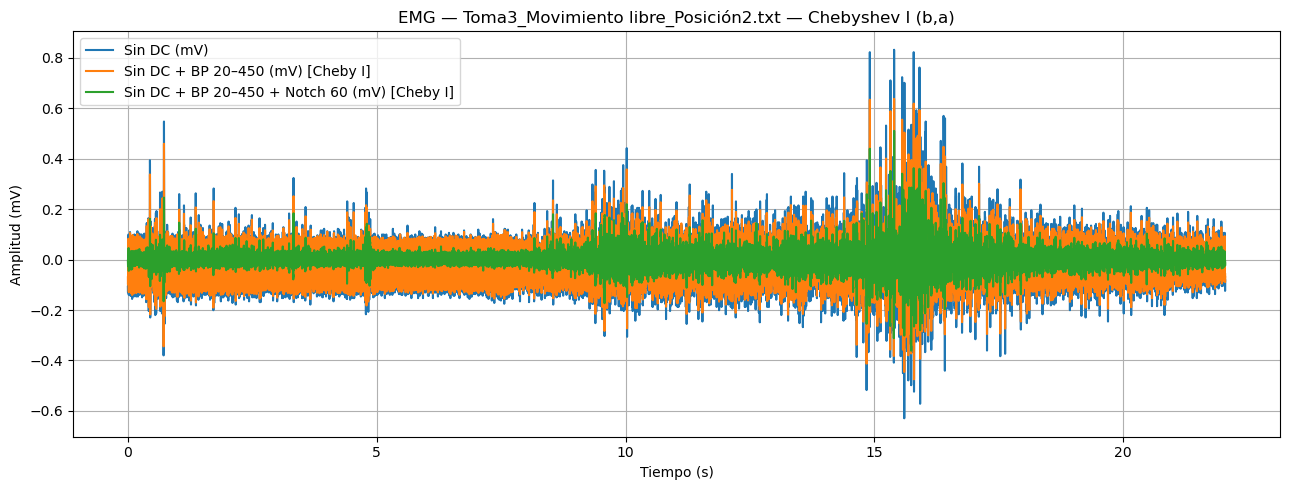

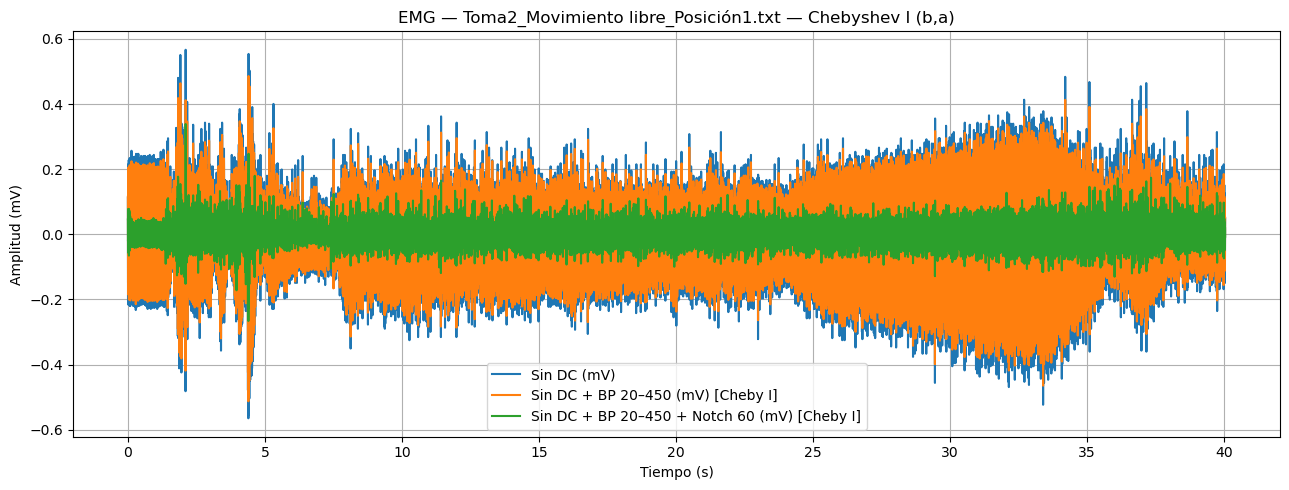

In [36]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import filtfilt

# ==============================
# Parámetros del sistema (BITalino)
# ==============================
fs       = 1000
canal    = 5
Vcc      = 3.3
GAIN_EMG = 1009
ADC_BITS = 10
ADC_MAX  = (2**ADC_BITS) - 1

# ==============================
# Rutas de filtros CHEBYSHEV I (ambos en (b,a) REALES)
# ==============================
archivo_bp    = r"C:\Users\RODRIGO\Desktop\GRUPO-04-ISB-2025-II\Laboratorios\Laboratorio 6 - Filtros\Extras\F20_EMG\chevishev_1.csv"  # 2 columnas: b,a
archivo_notch = r"C:\Users\RODRIGO\Desktop\GRUPO-04-ISB-2025-II\Laboratorios\Laboratorio 6 - Filtros\Extras\F60_EMG\Chevishev_1.csv"       # 2 columnas: b,a

# ==============================
# Cargar coeficientes (b,a) desde CSV (si usas ';', cambia delimiter)
# ==============================
arr_bp    = np.loadtxt(archivo_bp,    delimiter=',')
arr_notch = np.loadtxt(archivo_notch, delimiter=',')

b_bp, a_bp         = arr_bp[:, 0].astype(float),    arr_bp[:, 1].astype(float)
b_notch, a_notch   = arr_notch[:, 0].astype(float), arr_notch[:, 1].astype(float)

# ==============================
# Archivos EMG a procesar (una figura por archivo)
# ==============================
archivos_emg = [
    r"C:\Users\RODRIGO\Desktop\GRUPO-04-ISB-2025-II\Laboratorios\Laboratorio 3 - EMG\Registro de datos\Posición 2\Toma3_Movimiento libre_Posición2.txt",
    r"C:\Users\RODRIGO\Desktop\GRUPO-04-ISB-2025-II\Laboratorios\Laboratorio 3 - EMG\Registro de datos\Posición 1\Toma2_Movimiento libre_Posición1.txt"
]

# (opcional) recorte rápido para tests
recortar = False
i0, i1 = 7000, 17000

# ==============================
# Pipeline para cada archivo (sin funciones)
# ==============================
for archivo_emg in archivos_emg:
    # ---- Cargar canal EMG y convertir a mV ----
    datos = np.loadtxt(archivo_emg, dtype=float)   # separador automático (espacio/coma)
    cuentas_adc = datos[:, canal]
    if recortar:
        cuentas_adc = cuentas_adc[i0:i1]

    # 1) Centrar por mediana (≈ quitar Vcc/2 en cuentas)
    offset_counts = np.median(cuentas_adc)
    V_adc = (cuentas_adc - offset_counts) * (Vcc / ADC_MAX)  # Voltios a la salida del ADC (centrado en 0)

    # 2) Deshacer ganancia del canal EMG y pasar a mV
    V_in    = V_adc / GAIN_EMG
    senal_mV = 1e3 * V_in

    # 3) Quitar DC explícito (media residual en mV)
    senal_sin_dc = senal_mV - np.mean(senal_mV)

    # ---- Filtrado en dos etapas (b,a) reales desde pyFDA ----
    y_bp = filtfilt(b_bp, a_bp, senal_sin_dc, method="gust")        # 20–450 Hz
    y_bn = filtfilt(b_notch, a_notch, y_bp,       method="gust")    # Notch 60 Hz

    # ---- Tiempo y figura ----
    t = np.arange(len(senal_sin_dc)) / fs
    plt.figure(figsize=(13, 5))
    plt.plot(t, senal_sin_dc, label="Sin DC (mV)")
    plt.plot(t, y_bp,        label="Sin DC + BP 20–450 (mV) [Cheby I]")
    plt.plot(t, y_bn,        label="Sin DC + BP 20–450 + Notch 60 (mV) [Cheby I]")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud (mV)")
    plt.title(f"EMG — {archivo_emg.split('\\')[-1]} — Chebyshev I (b,a)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


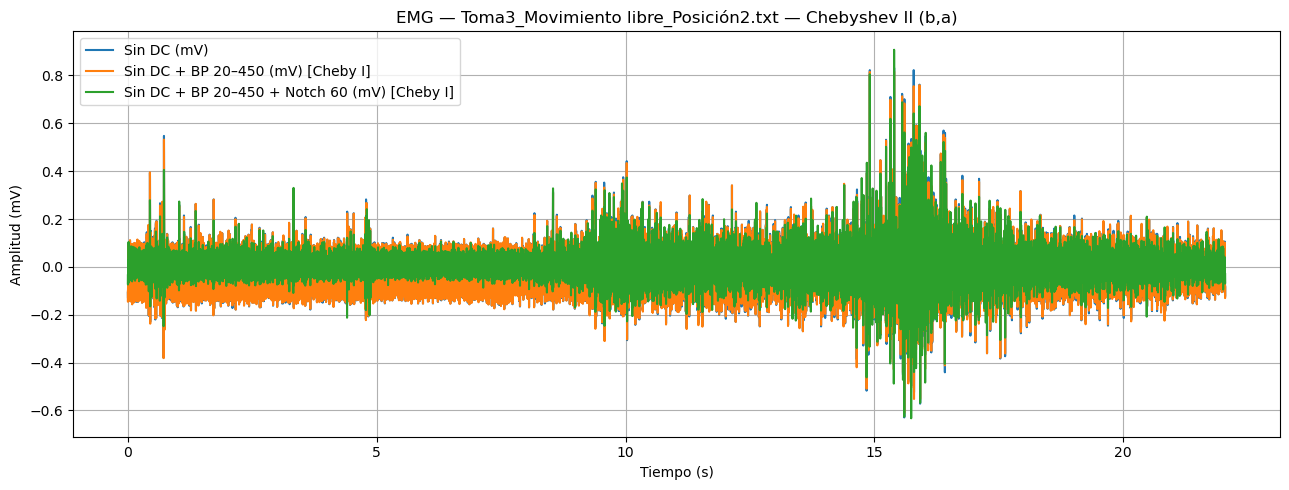

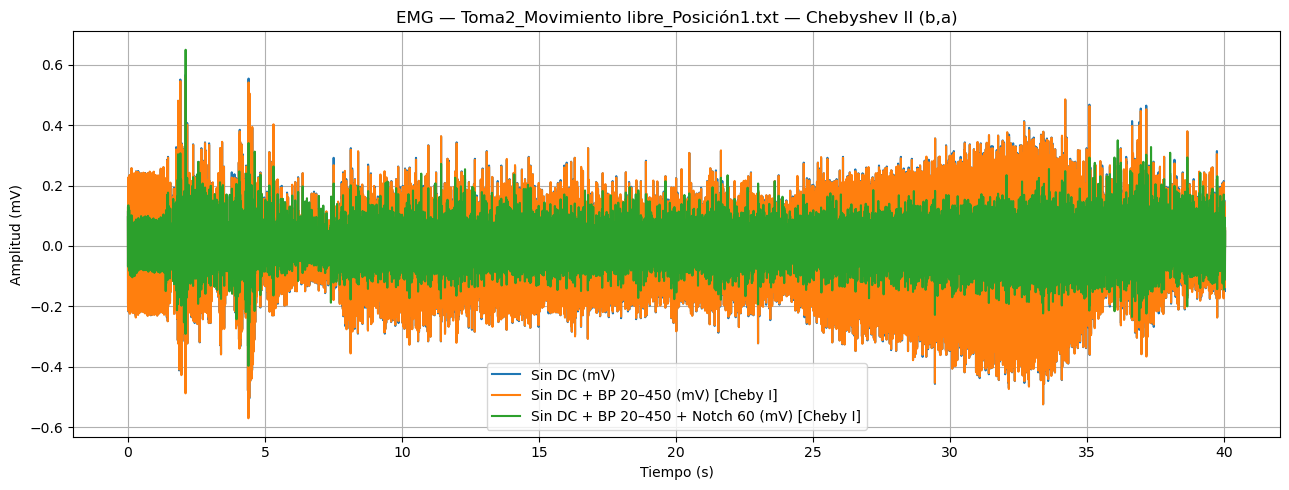

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import filtfilt

# ==============================
# Parámetros del sistema (BITalino)
# ==============================
fs       = 1000
canal    = 5
Vcc      = 3.3
GAIN_EMG = 1009
ADC_BITS = 10
ADC_MAX  = (2**ADC_BITS) - 1

# ==============================
# Rutas de filtros CHEBYSHEV I (ambos en (b,a) REALES)
# ==============================
archivo_bp    = r"C:\Users\RODRIGO\Desktop\GRUPO-04-ISB-2025-II\Laboratorios\Laboratorio 6 - Filtros\Extras\F20_EMG\chevishev_2.csv"
# Notch 60 Hz: 3 columnas con complejos -> (z, p, k)
archivo_notch = r"C:\Users\RODRIGO\Desktop\GRUPO-04-ISB-2025-II\Laboratorios\Laboratorio 6 - Filtros\Extras\F60_EMG\chevishev_2.csv"

# ==============================
# Cargar coeficientes (b,a) desde CSV (si usas ';', cambia delimiter)
# ==============================
arr_bp    = np.loadtxt(archivo_bp,    delimiter=',')
arr_notch = np.loadtxt(archivo_notch, delimiter=',')

b_bp, a_bp         = arr_bp[:, 0].astype(float),    arr_bp[:, 1].astype(float)
b_notch, a_notch   = arr_notch[:, 0].astype(float), arr_notch[:, 1].astype(float)

# ==============================
# Archivos EMG a procesar (una figura por archivo)
# ==============================
archivos_emg = [
    r"C:\Users\RODRIGO\Desktop\GRUPO-04-ISB-2025-II\Laboratorios\Laboratorio 3 - EMG\Registro de datos\Posición 2\Toma3_Movimiento libre_Posición2.txt",
    r"C:\Users\RODRIGO\Desktop\GRUPO-04-ISB-2025-II\Laboratorios\Laboratorio 3 - EMG\Registro de datos\Posición 1\Toma2_Movimiento libre_Posición1.txt"
]

# (opcional) recorte rápido para tests
recortar = False
i0, i1 = 7000, 17000

# ==============================
# Pipeline para cada archivo (sin funciones)
# ==============================
for archivo_emg in archivos_emg:
    # ---- Cargar canal EMG y convertir a mV ----
    datos = np.loadtxt(archivo_emg, dtype=float)   # separador automático (espacio/coma)
    cuentas_adc = datos[:, canal]
    if recortar:
        cuentas_adc = cuentas_adc[i0:i1]

    # 1) Centrar por mediana (≈ quitar Vcc/2 en cuentas)
    offset_counts = np.median(cuentas_adc)
    V_adc = (cuentas_adc - offset_counts) * (Vcc / ADC_MAX)  # Voltios a la salida del ADC (centrado en 0)

    # 2) Deshacer ganancia del canal EMG y pasar a mV
    V_in    = V_adc / GAIN_EMG
    senal_mV = 1e3 * V_in

    # 3) Quitar DC explícito (media residual en mV)
    senal_sin_dc = senal_mV - np.mean(senal_mV)

    # ---- Filtrado en dos etapas (b,a) reales desde pyFDA ----
    y_bp = filtfilt(b_bp, a_bp, senal_sin_dc, method="gust")        # 20–450 Hz
    y_bn = filtfilt(b_notch, a_notch, y_bp,       method="gust")    # Notch 60 Hz

    # ---- Tiempo y figura ----
    t = np.arange(len(senal_sin_dc)) / fs
    plt.figure(figsize=(13, 5))
    plt.plot(t, senal_sin_dc, label="Sin DC (mV)")
    plt.plot(t, y_bp,        label="Sin DC + BP 20–450 (mV) [Cheby I]")
    plt.plot(t, y_bn,        label="Sin DC + BP 20–450 + Notch 60 (mV) [Cheby I]")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud (mV)")
    plt.title(f"EMG — {archivo_emg.split('\\')[-1]} — Chebyshev II (b,a)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

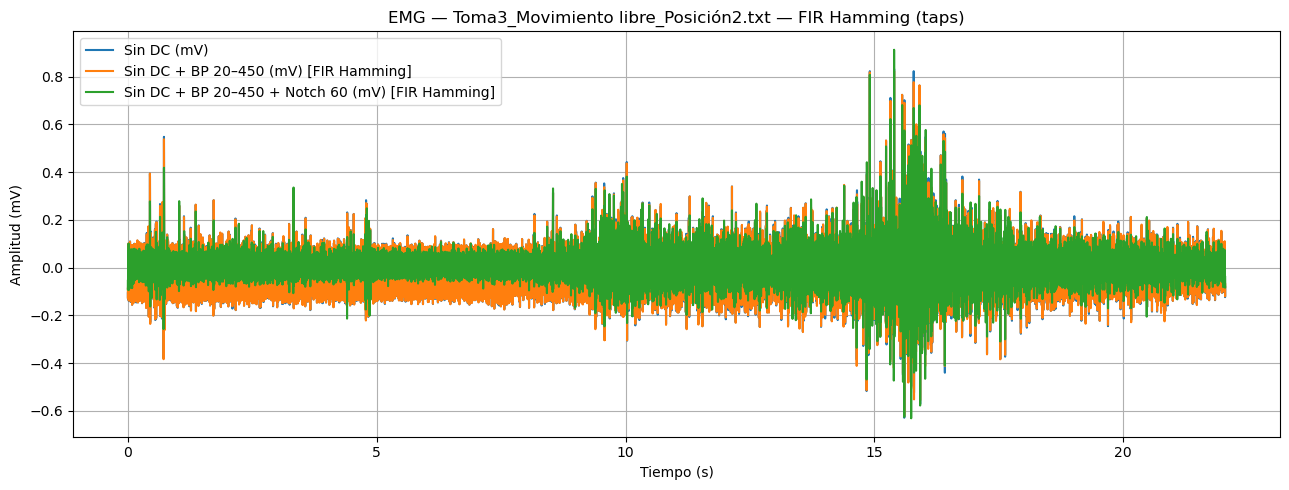

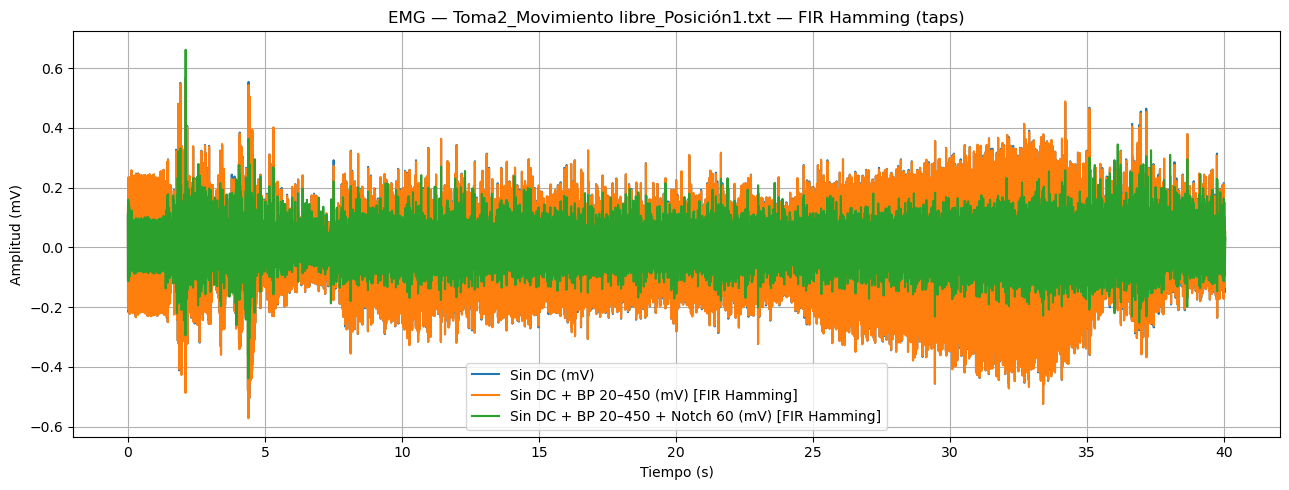

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import filtfilt

# ==============================
# Parámetros del sistema (BITalino)
# ==============================
fs       = 1000
canal    = 5
Vcc      = 3.3
GAIN_EMG = 1009
ADC_BITS = 10
ADC_MAX  = (2**ADC_BITS) - 1

# ==============================
# Rutas de filtros FIR (Hamming) — ambos con 1 columna (taps b)
# ==============================
archivo_bp    = r"C:\Users\RODRIGO\Desktop\GRUPO-04-ISB-2025-II\Laboratorios\Laboratorio 6 - Filtros\Extras\F20_EMG\hamming.csv"   # taps b (BP 20–450)
archivo_notch = r"C:\Users\RODRIGO\Desktop\GRUPO-04-ISB-2025-II\Laboratorios\Laboratorio 6 - Filtros\Extras\F60_EMG\Hamming.csv"      # taps b (Notch 60)

# ==============================
# Cargar taps FIR (1 columna) -> a = [1.0]
# ==============================
bp_raw = np.loadtxt(archivo_bp, delimiter=',')      # cambia a delimiter=';' si tu CSV usa ';'
nt_raw = np.loadtxt(archivo_notch, delimiter=',')

# Asegurar vectores 1D de taps
if bp_raw.ndim == 2 and bp_raw.shape[1] == 1:
    b_bp = bp_raw[:, 0].astype(float)
elif bp_raw.ndim == 1:
    b_bp = bp_raw.astype(float)
else:
    b_bp = bp_raw[:, 0].astype(float)

if nt_raw.ndim == 2 and nt_raw.shape[1] == 1:
    b_notch = nt_raw[:, 0].astype(float)
elif nt_raw.ndim == 1:
    b_notch = nt_raw.astype(float)
else:
    b_notch = nt_raw[:, 0].astype(float)

a_bp    = np.array([1.0], dtype=float)
a_notch = np.array([1.0], dtype=float)

# ==============================
# Archivos EMG a procesar (una figura por archivo)
# ==============================
archivos_emg = [
    r"C:\Users\RODRIGO\Desktop\GRUPO-04-ISB-2025-II\Laboratorios\Laboratorio 3 - EMG\Registro de datos\Posición 2\Toma3_Movimiento libre_Posición2.txt",
    r"C:\Users\RODRIGO\Desktop\GRUPO-04-ISB-2025-II\Laboratorios\Laboratorio 3 - EMG\Registro de datos\Posición 1\Toma2_Movimiento libre_Posición1.txt"
]

# (opcional) recorte rápido para tests
recortar = False
i0, i1 = 7000, 17000

# ==============================
# Pipeline
# ==============================
for archivo_emg in archivos_emg:
    # ---- Señal cruda -> mV ----
    datos = np.loadtxt(archivo_emg, dtype=float)
    x_adc = datos[:, canal]
    if recortar:
        x_adc = x_adc[i0:i1]

    # Centrado por mediana (≈ quitar Vcc/2) y conversión a mV
    offset_counts = np.median(x_adc)
    V_adc = (x_adc - offset_counts) * (Vcc / ADC_MAX)   # V salida ADC (centrado)
    V_in  = V_adc / GAIN_EMG                            # V a la entrada EMG
    x_mV  = 1e3 * V_in                                  # mV

    # Quitar DC explícito (media residual)
    x0 = x_mV - np.mean(x_mV)

    # ---- Filtrado: BP FIR -> Notch FIR ----
    y_bp = filtfilt(b_bp,    a_bp,    x0, method="gust")   # 20–450 Hz (FIR)
    y_bn = filtfilt(b_notch, a_notch, y_bp, method="gust") # Notch 60 Hz (FIR)

    # ---- Plot ----
    t = np.arange(len(x0)) / fs
    plt.figure(figsize=(13, 5))
    plt.plot(t, x0,   label="Sin DC (mV)")
    plt.plot(t, y_bp, label="Sin DC + BP 20–450 (mV) [FIR Hamming]")
    plt.plot(t, y_bn, label="Sin DC + BP 20–450 + Notch 60 (mV) [FIR Hamming]")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud (mV)")
    plt.title(f"EMG — {archivo_emg.split('\\')[-1]} — FIR Hamming (taps)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

## Filtrado de ECG

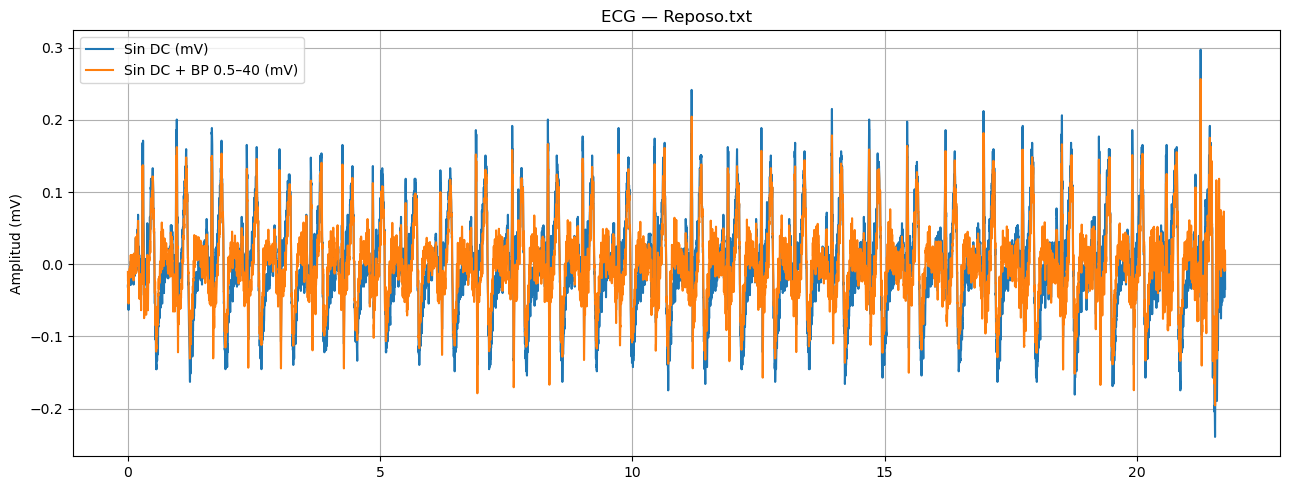

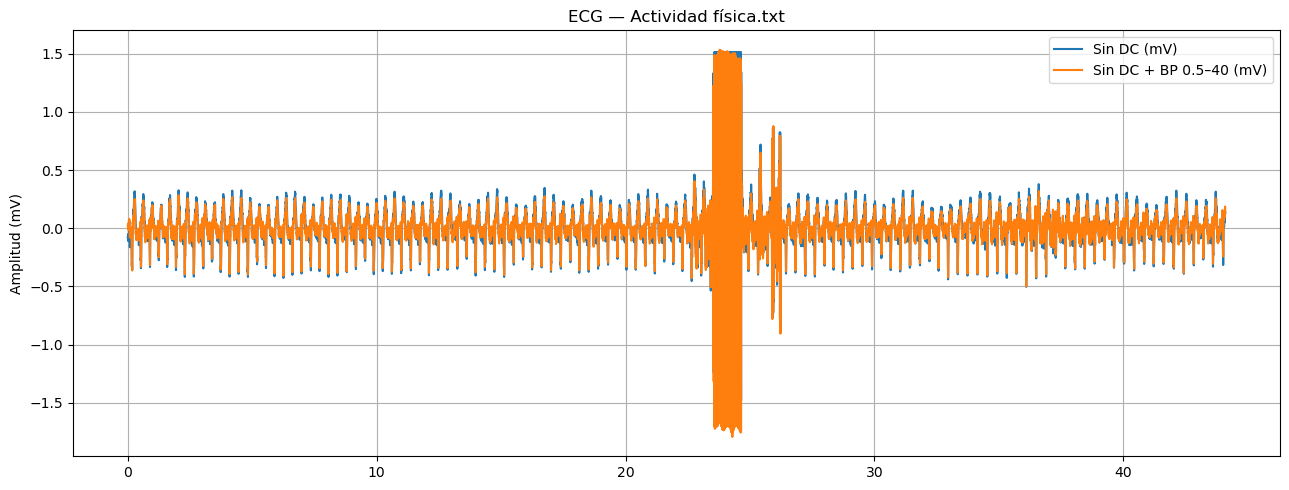

In [39]:
##FILTRO  BUTERWORDTH PASABANDA 0.5-40 Hz
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import filtfilt

# ==============================
# Parámetros del sistema (BITalino)
# ==============================
fs       = 1000
canal    = 5
Vcc      = 3.3
GAIN_ECG = 1100
ADC_BITS = 10
ADC_MAX  = (2**ADC_BITS) - 1

# ==============================
# Archivos de filtros (pyFDA: 2 columnas -> b, a)
# ==============================
archivo_bp    = r"C:\Users\RODRIGO\Desktop\GRUPO-04-ISB-2025-II\Laboratorios\Laboratorio 6 - Filtros\Extras\ECG_filtros y tomas\F_B_ECG.csv"

# Cargar coeficientes una sola vez
arr_bp    = np.loadtxt(archivo_bp, delimiter=',')

b_bp, a_bp       = arr_bp[:,0], arr_bp[:,1]


# ==============================
# Lista de archivos EMG a procesar (cada uno tendrá su propia figura)
# ==============================
archivos_ecg = [
    r"C:\Users\RODRIGO\Desktop\GRUPO-04-ISB-2025-II\Laboratorios\Laboratorio 6 - Filtros\Extras\ECG_filtros y tomas\Reposo.txt",
    r"C:\Users\RODRIGO\Desktop\GRUPO-04-ISB-2025-II\Laboratorios\Laboratorio 6 - Filtros\Extras\ECG_filtros y tomas\Actividad física.txt"
]

# ==============================
# Procesamiento y ploteo (sin funciones)
# ==============================
for archivo_ecg in archivos_ecg:
    # ---- Señal cruda -> mV ----
    datos = np.loadtxt(archivo_ecg, dtype=float)   # separador auto (espacios/comas)
    cuentas_adc = datos[:, canal]

    # Offset ~ Vcc/2: usamos la mediana para centrar explícitamente
    offset_counts = np.median(cuentas_adc)

    # Cuentas -> Voltios a la salida del ADC (centrado en 0)
    V_adc = (cuentas_adc - offset_counts) * (Vcc / ADC_MAX)

    # Quitar ganancia del canal ECG (obtener señal a la entrada del amplificador)
    V_in = V_adc / GAIN_ECG

    # A milivoltios
    senal_mV = 1e3 * V_in

    # Quitar DC explícito (media residual) — dejamos este paso claro en el código
    senal_sin_dc = senal_mV - np.mean(senal_mV)

    # ---- Filtrado en dos etapas ----
    # 1) Pasa-banda 0.5–40 (coef. de pyFDA)
    y_bp = filtfilt(b_bp, a_bp, senal_sin_dc, method="gust")


    # ---- Eje de tiempo ----
    t = np.arange(len(senal_sin_dc)) / fs

    # ---- Figura para este archivo ----
    plt.figure(figsize=(13, 5))
    plt.plot(t, senal_sin_dc, label="Sin DC (mV)")
    plt.plot(t, y_bp,label="Sin DC + BP 0.5–40 (mV)")
    plt.ylabel("Amplitud (mV)")
    plt.title(f"ECG — {archivo_ecg.split('\\')[-1]}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


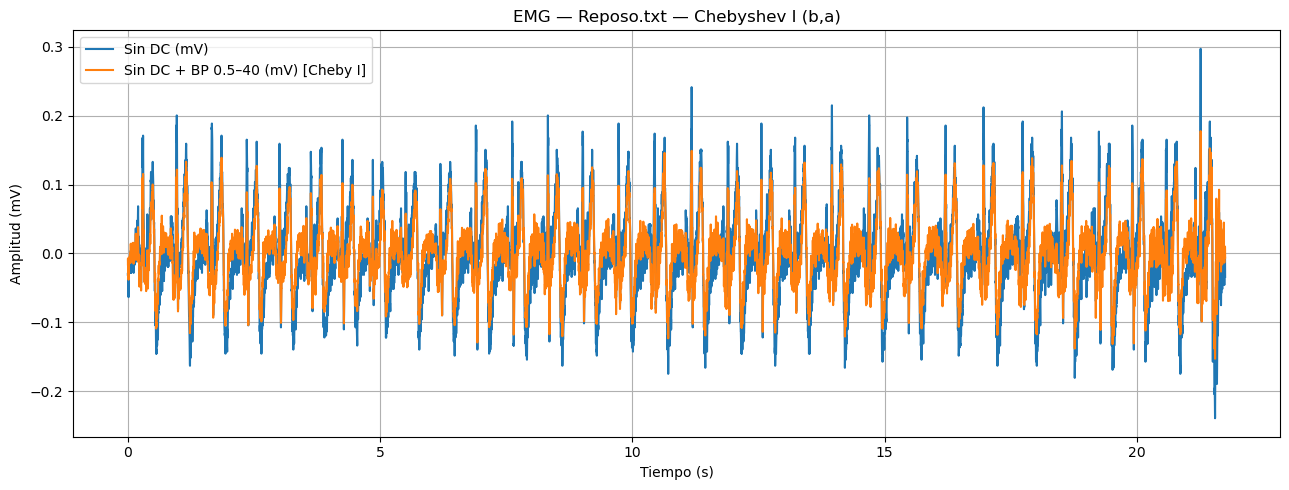

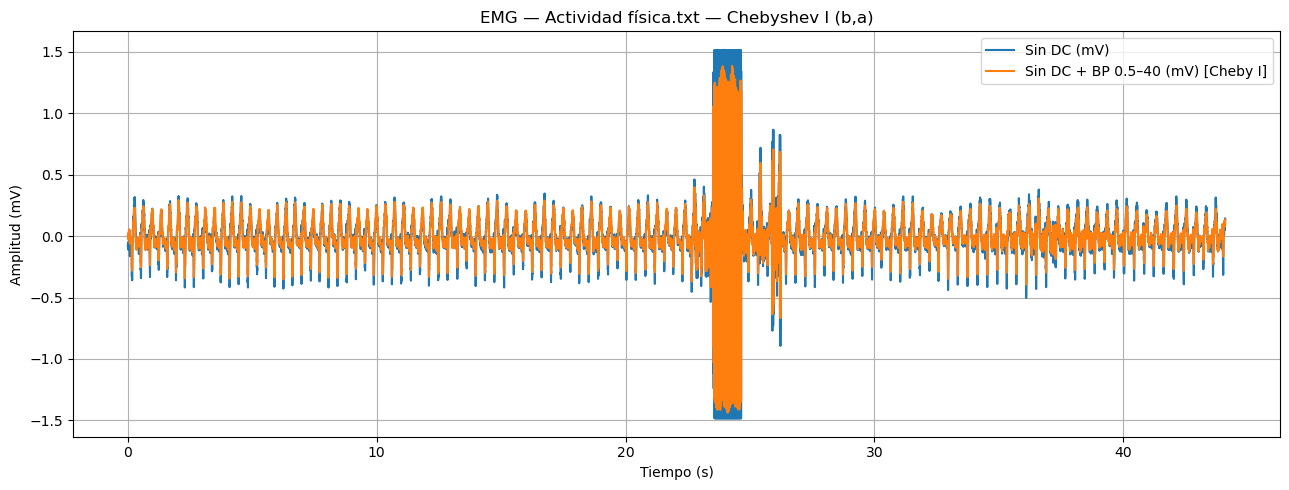

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import filtfilt

# ==============================
# Parámetros del sistema (BITalino)
# ==============================
fs       = 1000
canal    = 5
Vcc      = 3.3
GAIN_ECG = 1100
ADC_BITS = 10
ADC_MAX  = (2**ADC_BITS) - 1

# ==============================
# Rutas de filtros CHEBYSHEV I (ambos en (b,a) REALES)
# ==============================
archivo_bp    = r"C:\Users\RODRIGO\Desktop\GRUPO-04-ISB-2025-II\Laboratorios\Laboratorio 6 - Filtros\Extras\ECG_filtros y tomas\F_C1_ECG.csv" # 2 columnas: b,a      # 2 columnas: b,a

# ==============================
# Cargar coeficientes (b,a) desde CSV (si usas ';', cambia delimiter)
# ==============================
arr_bp    = np.loadtxt(archivo_bp,    delimiter=',')


b_bp, a_bp = arr_bp[0, :].astype(float),    arr_bp[1, :].astype(float)

# ==============================
# Archivos ECG a procesar (una figura por archivo)
# ==============================
archivos_ecg = [
    r"C:\Users\RODRIGO\Desktop\GRUPO-04-ISB-2025-II\Laboratorios\Laboratorio 6 - Filtros\Extras\ECG_filtros y tomas\Reposo.txt",
    r"C:\Users\RODRIGO\Desktop\GRUPO-04-ISB-2025-II\Laboratorios\Laboratorio 6 - Filtros\Extras\ECG_filtros y tomas\Actividad física.txt"
]

# (opcional) recorte rápido para tests
recortar = False
i0, i1 = 7000, 17000

# ==============================
# Pipeline para cada archivo (sin funciones)
# ==============================
for archivo_ecg in archivos_ecg:
    # ---- Cargar canal ECG y convertir a mV ----
    datos = np.loadtxt(archivo_ecg, dtype=float)   # separador automático (espacio/coma)
    cuentas_adc = datos[:, canal]
    if recortar:
        cuentas_adc = cuentas_adc[i0:i1]

    # 1) Centrar por mediana (≈ quitar Vcc/2 en cuentas)
    offset_counts = np.median(cuentas_adc)
    V_adc = (cuentas_adc - offset_counts) * (Vcc / ADC_MAX)  # Voltios a la salida del ADC (centrado en 0)

    # 2) Deshacer ganancia del canal EMG y pasar a mV
    V_in    = V_adc / GAIN_ECG
    senal_mV = 1e3 * V_in

    # 3) Quitar DC explícito (media residual en mV)
    senal_sin_dc = senal_mV - np.mean(senal_mV)

    # ---- Filtrado en dos etapas (b,a) reales desde pyFDA ----
    y_bp = filtfilt(b_bp, a_bp, senal_sin_dc, method="gust")        # 0.5–40 Hz

    # ---- Tiempo y figura ----
    t = np.arange(len(senal_sin_dc)) / fs
    plt.figure(figsize=(13, 5))
    plt.plot(t, senal_sin_dc, label="Sin DC (mV)")
    plt.plot(t, y_bp,        label="Sin DC + BP 0.5–40 (mV) [Cheby I]")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud (mV)")
    plt.title(f"EMG — {archivo_ecg.split('\\')[-1]} — Chebyshev I (b,a)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


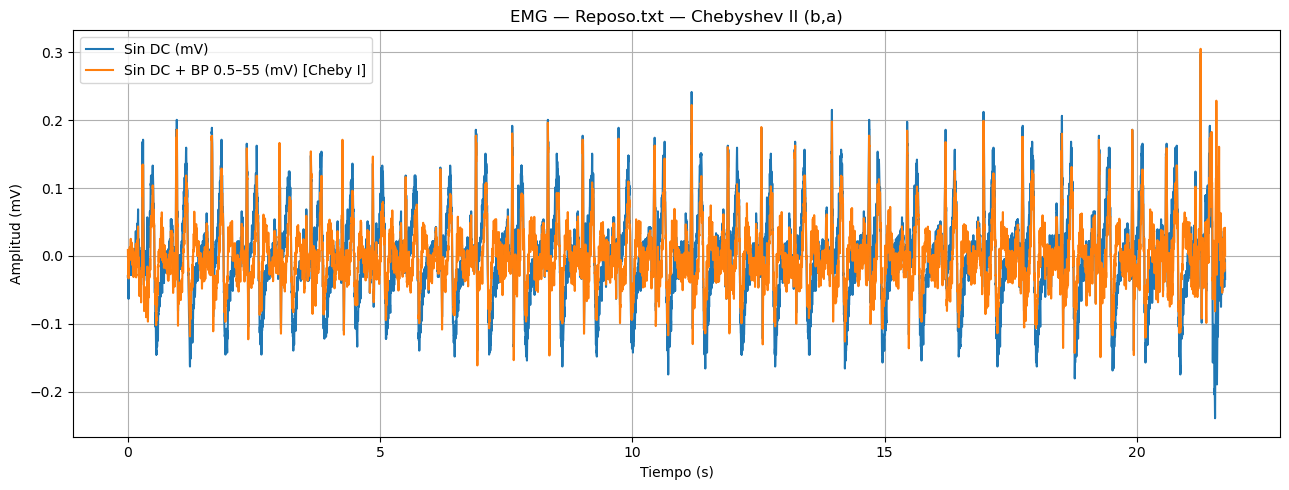

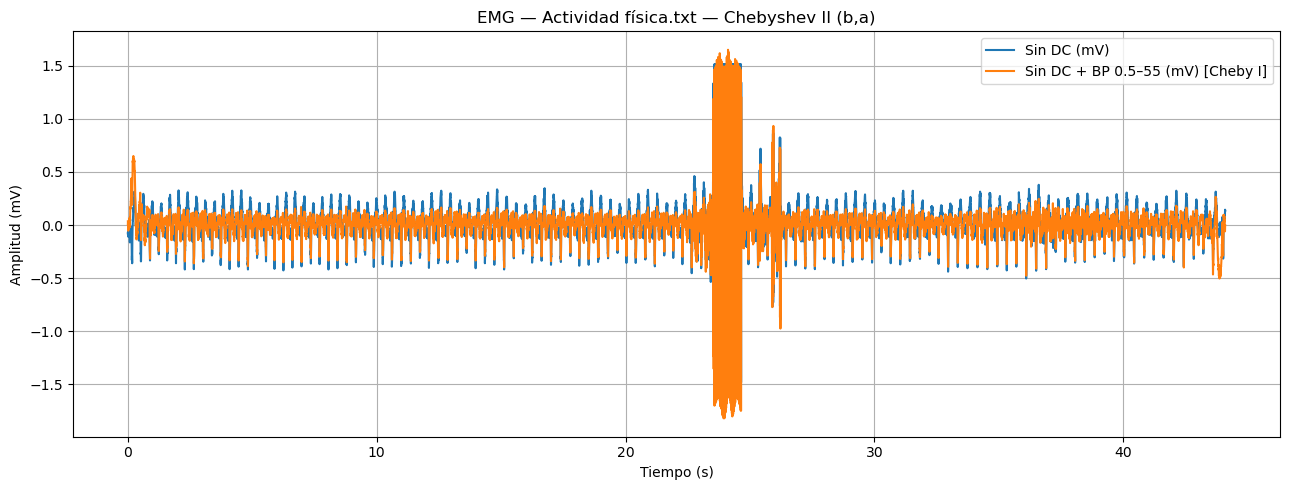

In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import filtfilt

# ==============================
# Parámetros del sistema (BITalino)
# ==============================
fs       = 1000
canal    = 5
Vcc      = 3.3
GAIN_ECG = 1100
ADC_BITS = 10
ADC_MAX  = (2**ADC_BITS) - 1

# ==============================
# Rutas de filtros CHEBYSHEV II (ambos en (b,a) REALES)
# ==============================
archivo_bp    = r"C:\Users\RODRIGO\Desktop\GRUPO-04-ISB-2025-II\Laboratorios\Laboratorio 6 - Filtros\Extras\ECG_filtros y tomas\F_C2_ECG.csv"

# ==============================
# Cargar coeficientes (b,a) desde CSV (si usas ';', cambia delimiter)
# ==============================
arr_bp    = np.loadtxt(archivo_bp,    delimiter=',')

b_bp, a_bp         = arr_bp[0, :].astype(float),    arr_bp[1, :].astype(float)

# ==============================
# Archivos ECG a procesar (una figura por archivo)
# ==============================
archivos_ecg = [
    r"C:\Users\RODRIGO\Desktop\GRUPO-04-ISB-2025-II\Laboratorios\Laboratorio 6 - Filtros\Extras\ECG_filtros y tomas\Reposo.txt",
    r"C:\Users\RODRIGO\Desktop\GRUPO-04-ISB-2025-II\Laboratorios\Laboratorio 6 - Filtros\Extras\ECG_filtros y tomas\Actividad física.txt"
]

# (opcional) recorte rápido para tests
recortar = False
i0, i1 = 7000, 17000

# ==============================
# Pipeline para cada archivo (sin funciones)
# ==============================
for archivo_ecg in archivos_ecg:
    # ---- Cargar canal EMG y convertir a mV ----
    datos = np.loadtxt(archivo_ecg, dtype=float)   # separador automático (espacio/coma)
    cuentas_adc = datos[:, canal]
    if recortar:
        cuentas_adc = cuentas_adc[i0:i1]

    # 1) Centrar por mediana (≈ quitar Vcc/2 en cuentas)
    offset_counts = np.median(cuentas_adc)
    V_adc = (cuentas_adc - offset_counts) * (Vcc / ADC_MAX)  # Voltios a la salida del ADC (centrado en 0)

    # 2) Deshacer ganancia del canal ECG y pasar a mV
    V_in    = V_adc / GAIN_ECG
    senal_mV = 1e3 * V_in

    # 3) Quitar DC explícito (media residual en mV)
    senal_sin_dc = senal_mV - np.mean(senal_mV)

    # ---- Filtrado en dos etapas (b,a) reales desde pyFDA ----
    y_bp = filtfilt(b_bp, a_bp, senal_sin_dc, method="gust")        # 0.5–55 Hz
    

    # ---- Tiempo y figura ----
    t = np.arange(len(senal_sin_dc)) / fs
    plt.figure(figsize=(13, 5))
    plt.plot(t, senal_sin_dc, label="Sin DC (mV)")
    plt.plot(t, y_bp,        label="Sin DC + BP 0.5–55 (mV) [Cheby I]")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud (mV)")
    plt.title(f"EMG — {archivo_ecg.split('\\')[-1]} — Chebyshev II (b,a)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

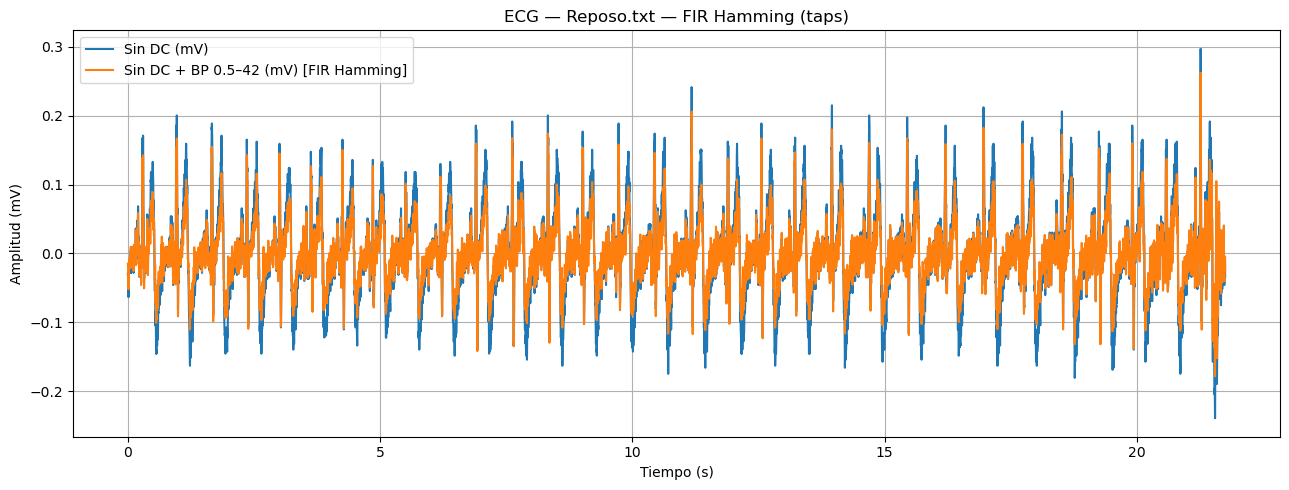

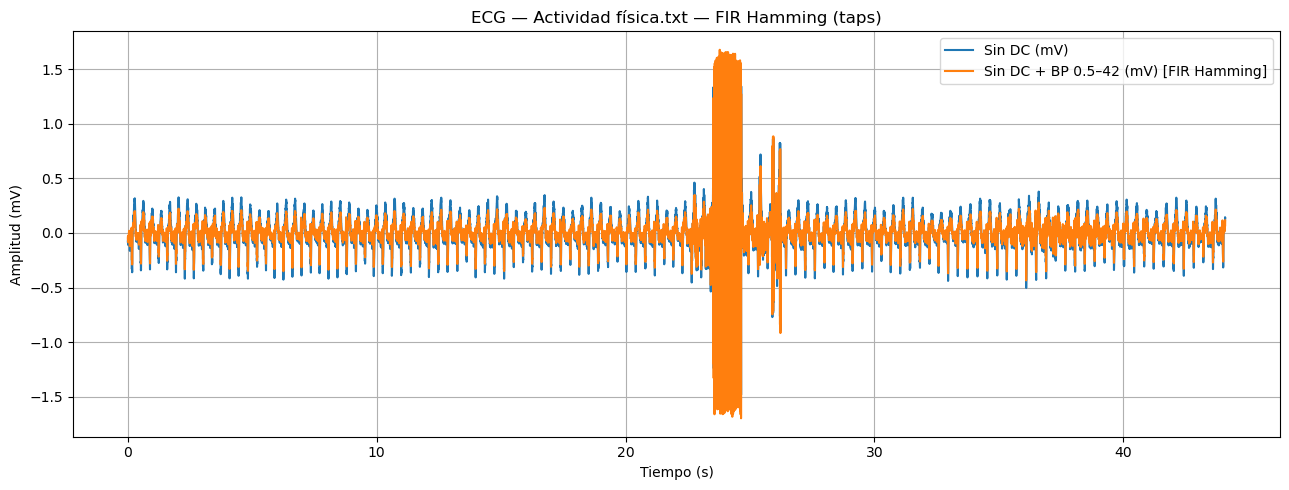

In [42]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import filtfilt

# ==============================
# Parámetros del sistema (BITalino)
# ==============================
fs       = 1000
canal    = 5
Vcc      = 3.3
GAIN_ECG = 1100
ADC_BITS = 10
ADC_MAX  = (2**ADC_BITS) - 1

# ==============================
# Rutas de filtros FIR (Hamming) — ambos con 1 columna (taps b)
# ==============================
archivo_bp    = r"C:\Users\RODRIGO\Desktop\GRUPO-04-ISB-2025-II\Laboratorios\Laboratorio 6 - Filtros\Extras\ECG_filtros y tomas\HAM_ECG.csv"   # taps b (BP 0.5–42)

# ==============================
# Cargar taps FIR (1 columna) -> a = [1.0]
# ==============================
bp_raw = np.loadtxt(archivo_bp, delimiter=',')      # cambia a delimiter=';' si tu CSV usa ';'


# Asegurar vectores 1D de taps
if bp_raw.ndim == 2 and bp_raw.shape[1] == 1:
    b_bp = bp_raw[:, 0].astype(float)
elif bp_raw.ndim == 1:
    b_bp = bp_raw.astype(float)
else:
    b_bp = bp_raw[:, 0].astype(float)

a_bp    = np.array([1.0], dtype=float)


# ==============================
# Archivos ECG a procesar (una figura por archivo)
# ==============================
archivos_ecg = [
    r"C:\Users\RODRIGO\Desktop\GRUPO-04-ISB-2025-II\Laboratorios\Laboratorio 6 - Filtros\Extras\ECG_filtros y tomas\Reposo.txt",
    r"C:\Users\RODRIGO\Desktop\GRUPO-04-ISB-2025-II\Laboratorios\Laboratorio 6 - Filtros\Extras\ECG_filtros y tomas\Actividad física.txt"
]

# (opcional) recorte rápido para tests
recortar = False
i0, i1 = 7000, 17000

# ==============================
# Pipeline
# ==============================
for archivo_ecg in archivos_ecg:
    # ---- Señal cruda -> mV ----
    datos = np.loadtxt(archivo_ecg, dtype=float)
    x_adc = datos[:, canal]
    if recortar:
        x_adc = x_adc[i0:i1]

    # Centrado por mediana (≈ quitar Vcc/2) y conversión a mV
    offset_counts = np.median(x_adc)
    V_adc = (x_adc - offset_counts) * (Vcc / ADC_MAX)   # V salida ADC (centrado)
    V_in  = V_adc / GAIN_ECG                            # V a la entrada ECG
    x_mV  = 1e3 * V_in                                  # mV

    # Quitar DC explícito (media residual)
    x0 = x_mV - np.mean(x_mV)

    # ---- Filtrado: BP FIR -> Notch FIR ----
    y_bp = filtfilt(b_bp,    a_bp,    x0, method="gust")   # 20–450 Hz (FIR)

    # ---- Plot ----
    t = np.arange(len(x0)) / fs
    plt.figure(figsize=(13, 5))
    plt.plot(t, x0,   label="Sin DC (mV)")
    plt.plot(t, y_bp, label="Sin DC + BP 0.5–42 (mV) [FIR Hamming]")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Amplitud (mV)")
    plt.title(f"ECG — {archivo_ecg.split('\\')[-1]} — FIR Hamming (taps)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()